In [1]:
import os, glob, subprocess, datetime

import pandas as pd
import geopandas as gpd
import numpy as np
import pickle as pkl
import scipy.stats as stats
import properscoring as ps
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from loading_utils import (_process_metadata, 
                           _process_training_curves, 
                           _process_testing_curves, 
                           _process_traning_forecasts, 
                           _process_testing_forecasts)

from matplotlib_scalebar.scalebar import ScaleBar
from sklearn.neighbors import KernelDensity
from scipy.integrate import quad
from scipy import interpolate
from ipywidgets import *
from sklearn.linear_model import BayesianRidge, LinearRegression
from scipy.stats import multivariate_normal, norm
from scipy.interpolate import make_smoothing_spline

plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.handleheight'] = 1.125
plt.rcParams['font.family']         = 'Avenir'

path_to_fPCA   = '/Users/Guille/Desktop/dynamic_update/software/fPCA'
path_to_fDepth = '/Users/Guille/Desktop/dynamic_update/software/fDepth'
path_to_data   = '/Users/Guille/Desktop/dynamic_update/data'
path_to_images = '/Users/Guille/Desktop/dynamic_update/images'

In [2]:
# Timestamps in interval
T = 288

# Loading color palette
palette_ = pd.read_csv(path_to_data + '/palette.csv')
print(palette_)

# Loading Texas map
TX_ = gpd.read_file(path_to_data + '/maps/TX/State.shp')
ERCOT_ = gpd.read_file(path_to_data + '/maps/ERCOT/eia-mod-BW-ERCOT-shapefile.shp')

# Loading and processing of sites metadata
meta_ = _process_metadata(file_name = '/wind_meta.xlsx', 
                          path      = path_to_data)
assets_ = meta_.index
X_tr_   = meta_[['lon', 'lat']].to_numpy()
print(X_tr_.shape)

meta_      = meta_.reset_index(drop = False)
vals, idx_ = np.unique(X_tr_, return_index = True, axis = 0)
assets_    = assets_[idx_]
X_tr_      = X_tr_[idx_, :]
print(assets_.shape)

idx_       = np.argsort(assets_)
assets_    = assets_[idx_]
X_tr_      = X_tr_[idx_, :]
print(assets_.shape)

# Loading and processing of historical curves for the training dataset
F_tr_, T_tr_, x_tr_, p_ = _process_training_curves(X_tr_, assets_, T,
                                                   file_name = '/actuals/wind_actual_5min_site_2017.csv',
                                                   path      = path_to_data)

print(F_tr_.shape, T_tr_.shape, x_tr_.shape, p_.shape)

# Loading and processing of historical curves for the testing dataset
F_ts_, T_ts_, x_ts_ = _process_testing_curves(X_tr_, assets_, p_, T,
                                              file_name = '/actuals/wind_actual_5min_site_2018.csv',
                                              path      = path_to_data)
print(F_ts_.shape, T_ts_.shape, x_ts_.shape)

# Loading and processing of historical day-ahead forecast for the training dataset
E_tr_ = _process_traning_forecasts(assets_, p_, T, 
                                   file_name = '/actuals/wind_day_ahead_forecast_2017.csv',
                                   path      = path_to_data)
print(E_tr_.shape)

# Loading and processing of historical day-ahead forecast for the testing dataset
E_ts_ = _process_testing_forecasts(assets_, p_, T,
                                   file_name = '/actuals/wind_day_ahead_forecast_2018.csv', 
                                   path      = path_to_data)
print(E_ts_.shape)

dt_ = np.array([t*5 for t in range(T)])
dx_ = pd.to_datetime(pd.DataFrame({'time': dt_}).time, unit = 'm').dt.strftime('%H:%M').to_numpy()
print(dt_.shape, dx_.shape)

t_ts_ = np.array([datetime.datetime.strptime(t_ts, '%Y-%m-%d').timetuple().tm_yday for t_ts in T_ts_]) - 1
t_tr_ = np.array([datetime.datetime.strptime(t_tr, '%Y-%m-%d').timetuple().tm_yday for t_tr in T_tr_]) - 1
print(t_tr_.shape, t_ts_.shape)

      miro      ibm
0  #013396  #648FFF
1  #B1C06E  #785EF0
2  #056534  #DC267F
3  #F80202  #FE6100
4  #FDD906  #FFB000
5  #FCF795      NaN
6  #CCEDFF      NaN
7  #FDD60B      NaN
8  #FCE9D0      NaN
(264, 2)
(187,)
(187,)
(104544, 187)
(67881, 288) (67881,) (67881, 2) (187,)
(105120, 1) (105120, 187)
0.0 1.0
(365, 288, 187) (365,) (187, 2)
0.0 0.9999999888984703
(67881, 288)
0.0 1.0
(365, 288, 187)
(288,) (288,)
(67881,) (365,)


In [3]:
D = int(F_tr_.shape[0]/p_.shape[0])
print(D)
F_tr_p_ = np.stack([F_tr_[i*D:(i + 1)*D, :] for i in range(p_.shape[0])])
print(F_tr_p_.shape)


363
(187, 363, 288)


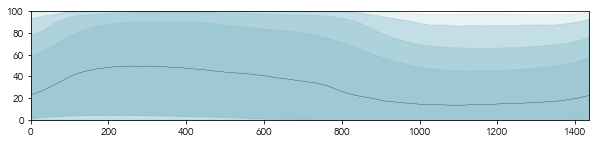

In [18]:
fig, ax = plt.subplots(figsize = (10, 2))  # Adjust figure size as needed

# Fill between the quantiles
ax.fill_between(dt_, 100.*np.percentile(F_tr_, 97.5, axis = 0), 100.*np.percentile(F_tr_, 2.5, axis = 0), 
                color = '#8dc0cd', 
                alpha = 0.2)

# Fill between the quantiles
ax.fill_between(dt_, 100.*np.percentile(F_tr_, 95, axis = 0), 100.*np.percentile(F_tr_, 5, axis = 0), 
                color = '#8dc0cd', 
                alpha = 0.4)

# Fill between the quantiles
ax.fill_between(dt_, 100.*np.percentile(F_tr_, 90, axis = 0), 100.*np.percentile(F_tr_, 10, axis = 0), 
                color = '#8dc0cd', 
                alpha = 0.4)

# Fill between the quantiles
ax.fill_between(dt_, 100.*np.percentile(F_tr_, 80, axis = 0), 100.*np.percentile(F_tr_, 10, axis = 0), 
                color = '#8dc0cd', 
                alpha = 0.45)

ax.plot(dt_, 100.*np.median(F_tr_, axis = 0), color = 'k', lw = .25)

ax.set_ylim(0, 100)
ax.set_xlim(dt_[0], dt_[-1])
plt.show()

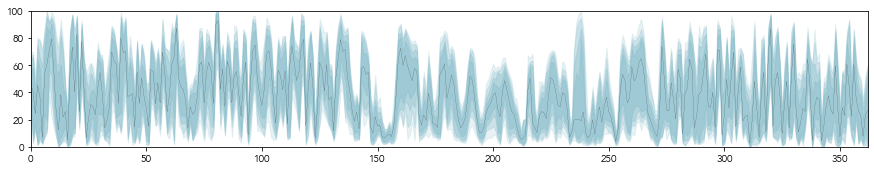

In [19]:
f_tr_bar_ = np.mean(F_tr_p_, axis = 2)

fig, ax = plt.subplots(figsize = (15, 2.5))  # Adjust figure size as needed

# Fill between the quantiles
ax.fill_between(range(363), 100.*np.percentile(f_tr_bar_, 97.5, axis = 0), 100.*np.percentile(f_tr_bar_, 2.5, axis = 0), 
                color = '#8dc0cd', 
                alpha = 0.2)

# Fill between the quantiles
ax.fill_between(range(363), 100.*np.percentile(f_tr_bar_, 95, axis = 0), 100.*np.percentile(f_tr_bar_, 5, axis = 0), 
                color = '#8dc0cd', 
                alpha = 0.3)

# Fill between the quantiles
ax.fill_between(range(363), 100.*np.percentile(f_tr_bar_, 90, axis = 0), 100.*np.percentile(f_tr_bar_, 10, axis = 0), 
                color = '#8dc0cd', 
                alpha = 0.4)

# Fill between the quantiles
ax.fill_between(range(363), 100.*np.percentile(f_tr_bar_, 80, axis = 0), 100.*np.percentile(f_tr_bar_, 20, axis = 0), 
                color = '#8dc0cd', 
                alpha = 0.5)

ax.plot(range(363), 100.*np.median(f_tr_bar_, axis = 0), color = 'k', lw = .125)

ax.set_ylim(0, 100)
ax.set_xlim(0, 362)
plt.show()

(95832, 288)


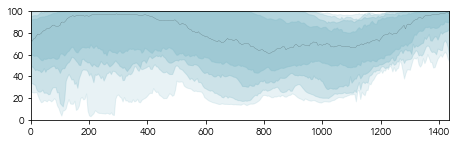

In [20]:
print(F_tr_.shape)

d = 100
f_tr_ = F_tr_p_[:, d, :]

fig, ax = plt.subplots(figsize = (7.5, 2))  # Adjust figure size as needed

# Fill between the quantiles
ax.fill_between(dt_, 100.*np.percentile(f_tr_, 97.5, axis = 0), 100.*np.percentile(f_tr_, 2.5, axis = 0), 
                color = '#8dc0cd', 
                alpha = 0.2)

# Fill between the quantiles
ax.fill_between(dt_, 100.*np.percentile(f_tr_, 95, axis = 0), 100.*np.percentile(f_tr_, 5, axis = 0), 
                color = '#8dc0cd', 
                alpha = 0.3)

# Fill between the quantiles
ax.fill_between(dt_, 100.*np.percentile(f_tr_, 90, axis = 0), 100.*np.percentile(f_tr_, 10, axis = 0), 
                color = '#8dc0cd', 
                alpha = 0.4)

# Fill between the quantiles
ax.fill_between(dt_, 100.*np.percentile(f_tr_, 80, axis = 0), 100.*np.percentile(f_tr_, 20, axis = 0), 
                color = '#8dc0cd', 
                alpha = 0.5)

ax.plot(dt_, 100.*np.median(f_tr_, axis = 0), color = 'k', lw = .125)

ax.set_ylim(0, 100)
ax.set_xlim(dt_[0], dt_[-1])
plt.show()

(95832, 288)
(67, 288)


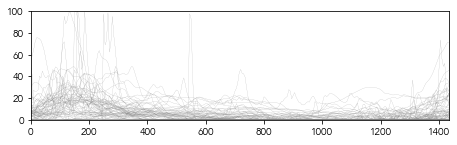

In [38]:
print(F_tr_.shape)

a = 133
f_tr_ = F_tr_p_[a, ...]

fig, ax = plt.subplots(figsize = (7.5, 2))  # Adjust figure size as needed

# # Fill between the quantiles
# ax.fill_between(dt_, 100.*np.percentile(f_tr_, 97.5, axis = 0), 100.*np.percentile(f_tr_, 2.5, axis = 0), 
#                 color = '#8dc0cd', 
#                 alpha = 0.2)

# # Fill between the quantiles
# ax.fill_between(dt_, 100.*np.percentile(f_tr_, 95, axis = 0), 100.*np.percentile(f_tr_, 5, axis = 0), 
#                 color = '#8dc0cd', 
#                 alpha = 0.3)

# # Fill between the quantiles
# ax.fill_between(dt_, 100.*np.percentile(f_tr_, 90, axis = 0), 100.*np.percentile(f_tr_, 10, axis = 0), 
#                 color = '#8dc0cd', 
#                 alpha = 0.4)

# # Fill between the quantiles
# ax.fill_between(dt_, 100.*np.percentile(f_tr_, 80, axis = 0), 100.*np.percentile(f_tr_, 20, axis = 0), 
#                 color = '#8dc0cd', 
#                 alpha = 0.5)

# ax.plot(dt_, 100.*np.median(f_tr_, axis = 0), color = 'k', lw = .125)
print(f_tr_[np.mean(f_tr_, axis = 1) < 0.1,].shape)


ax.plot(dt_, 100.*f_tr_[np.mean(f_tr_, axis = 1) < 0.1,].T, color = 'gray', lw = .125)

ax.set_ylim(0, 100)
ax.set_xlim(dt_[0], dt_[-1])
plt.show()

(95832, 2) (95832, 288) (95832, 288)


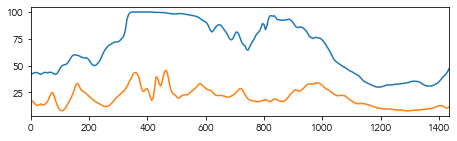

In [102]:
print(x_tr_.shape, F_tr_.shape, E_tr_.shape)

k = 1
fig, ax = plt.subplots(figsize = (7.5, 2))  # Adjust figure size as needed

ax.plot(dt_, 100.*F_tr_p_[203, k, ])
ax.plot(dt_, 100.*F_tr_p_[204, k, ])

#ax.set_ylim(0, 100)
ax.set_xlim(dt_[0], dt_[-1])
plt.show()

In [3]:
from mpl_toolkits.basemap import Basemap

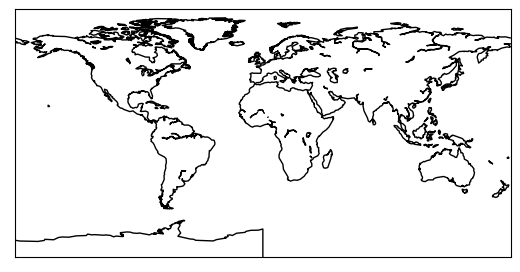

<Figure size 640x480 with 0 Axes>

In [8]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

map = Basemap(llcrnrlon=-93.,llcrnrlat=40.,urcrnrlon=-75.,urcrnrlat=50.,
             resolution='i', projection='tmerc', lat_0 = 40., lon_0 = -80)

map.drawmapboundary(fill_color='aqua')
map.fillcontinents(color='#cc9955', lake_color='aqua')

map.drawcounties()

plt.show()


[ 83.33333333 333.33333333 666.66666667]
26.1186 36.4978
-104.742 -95.4551


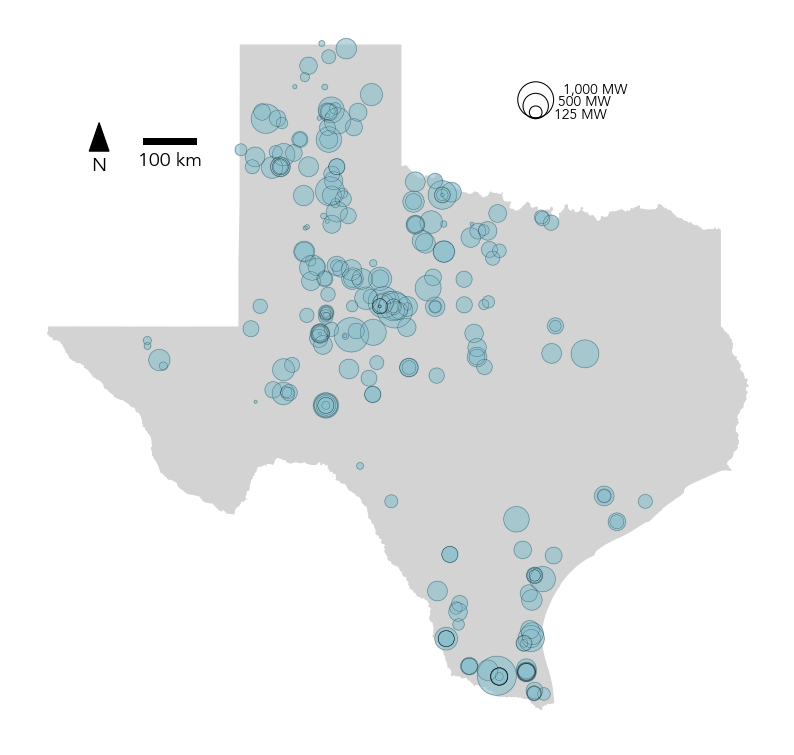

In [4]:
fig, ax = plt.subplots(figsize = (10, 10))  # Adjust figure size as needed


TX_.plot(ax        = ax, 
         facecolor = 'lightgray', 
         edgecolor = 'white')

scale = 1.5
ax.scatter(meta_['lon'], meta_['lat'], s     = meta_['capacity']/scale, 
                                       c     = '#8dc0cd', 
                                       alpha = 0.625)

ax.scatter(meta_['lon'], meta_['lat'], s         = meta_['capacity']/scale,
                                       edgecolor = 'k', 
                                       lw        = .125, 
                                       facecolor = 'None')

loc_ = [-97.5, 35.5]
size_ = np.array([125, 500, 1000])/scale
print(size_)
ax.scatter(loc_[0], loc_[1] - .1, 
           s         = size_[0],
           edgecolor = 'k', 
           lw        = .75, 
           facecolor = 'None')

ax.annotate('125 MW', (loc_[0] + .35, loc_[1] - .2), size = 10)

ax.scatter(loc_[0], loc_[1], 
           s         = size_[1],
           edgecolor = 'k', 
           lw        = .75, 
           facecolor = 'None')

ax.annotate('500 MW', (loc_[0] + .425, loc_[1]), size = 10)

ax.scatter(loc_[0], loc_[1] + .1, 
           s         = size_[2],
           edgecolor = 'k', 
           lw        = .75, 
           facecolor = 'None')
ax.annotate('1,000 MW', (loc_[0] + .5, loc_[1] + .2), size = 10)

print(meta_['lat'].min(), meta_['lat'].max())
print(meta_['lon'].min(), meta_['lon'].max())

# Add compass (North arrow)
x, y, arrow_length = 0.115, 0.85, .0625  # relative axes coords
ax.annotate('N', xy         = (x, y), 
                 xytext     = (x, y - arrow_length),
                 arrowprops = dict(facecolor='k', arrowstyle = 'wedge,tail_width=1,shrink_factor=.5' ),
                 ha         = 'center', 
                 va         = 'center',
                 fontsize   = 14,
                 xycoords   = ax.transAxes)

scalebar = ScaleBar(dx              = 100,  # scaling factor
                    units           = 'km', 
                    dimension       = 'si-length',  # could also be 'imperial-length'
                    location        = 'upper left',
                    length_fraction = .075,  # fraction of the axis for bar length
                    color           = 'black',
                    box_color       = 'None',
                    box_alpha       = 1.,
                    border_pad      = 9,
                    font_properties = {'size': 14})

ax.add_artist(scalebar)

ax.set_axis_off()

plt.show()

(264, 2)


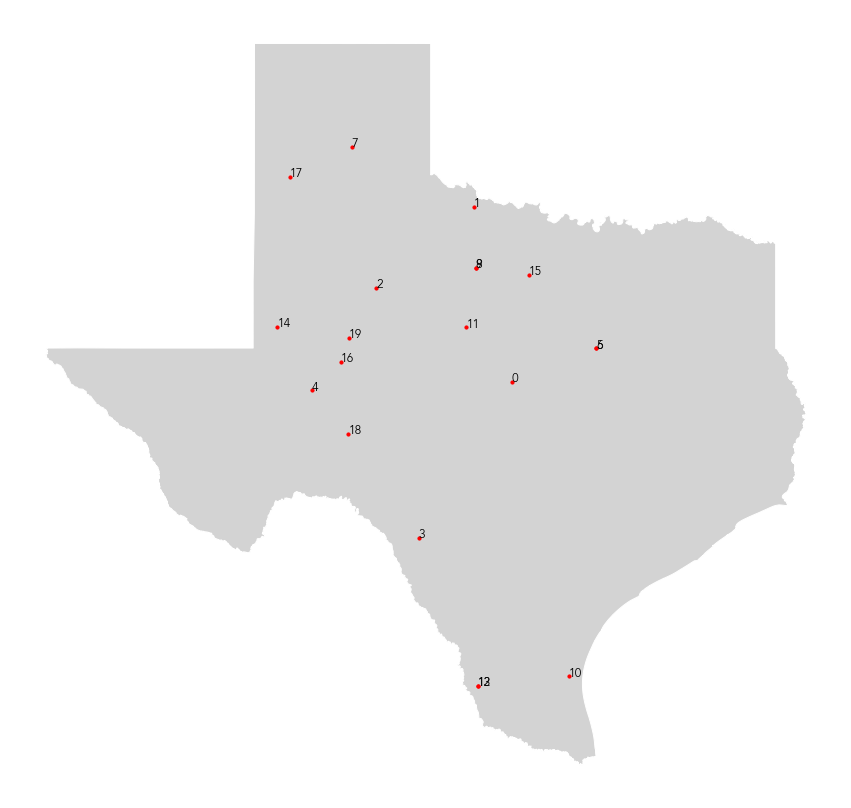

In [19]:
# Dense: 48, 87, 109, 110, 115
# Sparse: 1, 91, 248, 158, 116
meta_p_ = meta_.reset_index(drop = True).copy()
fig, ax = plt.subplots(figsize = (15, 15))  # Adjust figure size as needed
print(x_ts_.shape)
TX_.plot(ax        = ax, 
         facecolor = 'lightgray', 
         edgecolor = 'white')

for i in range(20):
    ax.scatter(x_ts_[i, 0], x_ts_[i, 1], s = 10., c = 'r')

    ax.annotate(i, (x_ts_[i, 0], x_ts_[i, 1]), size = 12)

ax.set_axis_off()

plt.savefig(path_to_images + r'/index_map.pdf', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

In [3]:
import os, glob, datetime

import pandas as pd
import numpy as np

#from scipy.interpolate import make_smoothing_spline
from scipy import interpolate




                              lon      lat  capacity
name                                                
Amazon Wind Farm Texas  -100.9360  32.8825     330.0
Anacacho Wind Farm      -100.1920  29.1922     129.0
Baffin                   -97.6064  27.1436     264.0
Barton Chapel Wind Farm  -98.3008  33.0733     157.0
Bearkat I               -101.5460  31.7931     257.0
...                           ...      ...       ...
White Mesa Wind         -101.4121  30.7230     500.0
Whitehorse Wind         -100.4022  32.7428     418.9
Wildrose Wind           -101.7350  34.5304     302.5
Wilson Ranch            -100.5385  30.8975     199.5
WKN Amadeus Wind        -100.4022  32.7428     245.9

[264 rows x 3 columns]


In [91]:
# Timestamps in interval
T = 288
K = 264

ac_tr_  = pd.read_csv(path_to_data + '/actuals/wind_actual_5min_site_2017.csv')
ac_tr_  = ac_tr_.iloc[T:-T]
assets_ = ac_tr_.columns[1:K+1]
print(assets_)

dates_ = ac_tr_[['Time']].to_numpy()
print(dates_.shape)

# Consitent asset ordering
ac_tr_ = ac_tr_[assets_].to_numpy()
print(ac_tr_.shape)

Index(['Aguayo Wind', 'Ajax Wind', 'Amazon Wind Farm Texas',
       'Anacacho Wind Farm', 'Appaloosa Run Renewable Energy Project',
       'Aquilla Lake', 'Aquilla Lake 2 Wind', 'Armstrong Wind',
       'Azure Sky Wind 1', 'Azure Sky Wind 2',
       ...
       'White Tail', 'Whitehorse Wind', 'Wildorado Wind Farm', 'Wildrose Wind',
       'Willow Springs Wind Farm', 'Wilson Ranch',
       'Wind Power Partners '94 Wind Farm', 'Windthorst-2',
       'Wolf Ridge Wind Farm', 'Woodward Mountain I & II Wind Farm'],
      dtype='object', length=264)
(104544, 1)
(104544, 264)


In [93]:
F_tr_     = []
dates_tr_ = []
for i in range(int(ac_tr_.shape[0]/T)):
    dates_tr_.append(dates_[i*T:(i+1)*T, :])
    F_tr_.append(ac_tr_[i*T:(i+1)*T, :])
    
F_tr_     = np.stack(F_tr_)
dates_tr_ = np.stack(dates_tr_)[..., 0]
print(F_tr_.shape, dates_tr_.shape)

(363, 288, 264) (363, 288)


In [94]:
meta_ = pd.read_excel(path_to_data + '/wind_meta.xlsx')
meta_ = meta_.rename(columns = {'lati': 'lat', 
                                'longi': 'lon', 
                                'Facility.Name': 'name', 
                                'Capacity': 'capacity'})  

meta_ = meta_[['name', 'lon', 'lat', 'capacity']].set_index('name')
X_tr_ = meta_.loc[assets_, ['lon', 'lat']].to_numpy()
print(X_tr_.shape)

meta_      = meta_.reset_index(drop = False)
vals, idx_ = np.unique(X_tr_, return_index = True, axis = 0)
idx_       = np.sort(idx_)
print(idx_.shape)

X_tr_ = X_tr_[idx_, :]
F_tr_ = F_tr_[..., idx_]
print(F_tr_.shape, X_tr_.shape)

(264, 2)
(187,)
(363, 288, 187) (187, 2)


In [95]:
# Normalized between 0 and 1 by Max Power
p_ = np.max(ac_tr_, axis = 0)
print(p_.shape)

# Utilize Max power in metadata
p_ = p_[idx_]
print(p_.shape)

for i in range(p_.shape[0]):
    F_tr_[..., i] /= p_[i]
print(F_tr_.min(), F_tr_.max())

x_tr_ = []
for i in range(X_tr_.shape[0]):
    for _ in range(F_tr_.shape[0]):
        x_tr_.append(X_tr_[i, :])
x_tr_ = np.stack(x_tr_)
print(x_tr_.shape)

# Format random curves
F_tr_ = np.concatenate([F_tr_[..., i] for i in range(F_tr_.shape[-1])], axis = 0)
print(F_tr_.shape)

# Curve dates
T_tr_ = np.concatenate([dates_tr_[:, 0] for i in range(p_.shape[0])], axis = 0)
T_tr_ = np.stack([T_tr_[i][:10] for i in range(T_tr_.shape[0])], axis = 0)
print(T_tr_.shape)

(264,)
(187,)
0.0 1.0
(67881, 2)
(67881, 288)
(67881,)


['2017-01-02' '2017-01-03' '2017-01-04' ... '2017-12-28' '2017-12-29'
 '2017-12-30']
363 (67881,)
187 (67881,)
(1, 288)
                name      lon      lat  capacity
203    Loma Pinta II -99.0997  28.3451     201.6
204  Loma Pinta Wind -99.0997  28.3451     200.0


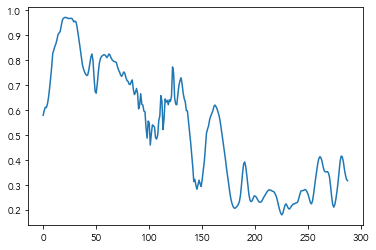

In [105]:
lon  = -99.0997  
lat  = 28.3451
date = '2017-01-06'
print(T_tr_)

idx_1_ = (x_tr_[:, 0] == lon) & (x_tr_[:, 1] == lat)
print(idx_1_.sum(), idx_1_.shape)

idx_2_ = T_tr_ == date
print(idx_2_.sum(), idx_2_.shape)

f_tr_ = F_tr_[idx_1_ & idx_2_, ...]
print(f_tr_.shape)

print(meta_.loc[(meta_['lon'] == lon) & (meta_['lat'] == lat)])

plt.figure()
plt.plot(f_tr_.T)
plt.show()

In [ ]:
def _exp(ac_tr_, ac_ts_, date_ts_, interval_, horizon_, params_, verbose = True):
    
    if verbose: print(horizon_, interval_)
    
    f_ts_hat_all_ = [[] for horizon in range(horizon_[0])]
    s_ts_hat_all_ = [[] for horizon in range(horizon_[0])]
    f_ts_all_     = [[] for horizon in range(horizon_[0])]

    for yearday in range(ac_ts_.shape[0]):
        for interval in range(interval_[0], interval_[1], interval_[2]):
            interval *= 12
            F_tr_, F_ts_, f_tr_, f_ts_, t_tr_, t_ts_ = _test_fc(ac_tr_, ac_ts_, date_ts_,
                                                                i_day   = yearday, 
                                                                t_event = interval,
                                                                viz     = False)

            idx_1_ = f_ts_ <= F_tr_.min()
            idx_2_ = f_ts_ >= F_tr_.max()
        
            if (idx_1_.sum() + idx_2_.sum()) == 0.:
                f_ts_hat_, S_ts_hat_, F_ts_scen_ = _fknn_fc(F_tr_, f_tr_, F_ts_,
                                                            forget_rate  = params_['forget_rate'], 
                                                            prob         = params_['prob'],
                                                            k            = params_['k'],
                                                            length_scale = params_['length_scale'],
                                                            smoothing    = params_['smoothing'],
                                                            lamdba       = params_['lamdba'],
                                                            viz          = False)

                # _plot_results(F_tr_, 
                #               S_ts_hat_, 
                #               f_ts_hat_, 
                #               f_tr_,
                #               f_ts_, 
                #               t_tr_, t_ts_, date_ts_, yearday, interval)
                s_ts_hat_ = np.sqrt(np.diagonal(S_ts_hat_))
                # idx_ = s_ts_hat_ == 0.
                # if idx_.sum() > 0.:
                #     print(yearday)
                for horizon in range(horizon_[0]):
                    h0  = horizon
                    h0 *= 12
                    h0 *= horizon_[1]

                    h1  = horizon + 1
                    h1 *= 12
                    h1 *= horizon_[1]

                    if h1 > s_ts_hat_.shape[0]:
                        continue
                    else:
                        f_ts_hat_all_[horizon].append(f_ts_hat_[h0:h1])
                        s_ts_hat_all_[horizon].append(s_ts_hat_[h0:h1])
                        f_ts_all_[horizon].append(f_ts_[h0:h1])

    f_ts_hat_ = [np.concatenate(f_ts_hat_all_[horizon], axis = 0) for horizon in range(horizon_[0])]
    s_ts_hat_ = [np.concatenate(s_ts_hat_all_[horizon], axis = 0) for horizon in range(horizon_[0])]
    f_ts_     = [np.concatenate(f_ts_all_[horizon], axis = 0) for horizon in range(horizon_[0])]
    return f_ts_, f_ts_hat_, s_ts_hat_


def _PIT(y_true, forecast_mean, forecast_std, nbins = 30):
    """
    Calculate the Probabilistic Integral Transform (PIT).
    
    Parameters:
    - y_true: Observed (true) values
    - forecast_mean: Mean of the predicted distribution (e.g., mean of the normal distribution)
    - forecast_std: Standard deviation of the predicted distribution
    
    Returns:
    - mean and std: The calculated PIT
    """
            
    u_samples = norm.cdf(y_true, loc = forecast_mean, scale = forecast_std)
    
    # Plot the histogram of U to check if it's uniformly distributed
    plt.figure(figsize = (12.5, 2.5))
    plt.hist(u_samples, bins    = nbins, 
                        density = True, 
                        alpha   = 0.7, 
                        color   = 'blue', 
                        label   = 'Transformed (U)')
    
    plt.hlines(1, 0, 1, color     = 'red', 
                        linestyle = '--', 
                        label     = 'Uniform distribution')
    
    plt.title('Probabilistic Integral Transform')
    plt.xlabel('U')
    plt.ylabel('PDF')
    plt.legend()

    
params_ = {'method': 'fknn_fc',
           'forget_rate':  1,
           'length_scale': 10,
           'k':            250,
           'prob':         0.9,
           'smoothing':      0,
           'lamdba':         0}

horizon_  = [8, 1]
interval_ = [4, 16, 1]

f_ts_, f_ts_hat_, s_ts_hat_ = _exp(ac_tr_, ac_ts_, date_ts_, interval_, horizon_, params_)
print(len(f_ts_))
for horion in range(len(f_ts_)):
    print(f_ts_[horion].shape)
    _PIT(f_ts_[horion], f_ts_hat_[horion], s_ts_hat_[horion])
